In [1]:

import numpy as np
import mosek
import math
import matplotlib.pyplot as plt
import cvxpy as cp
from tqdm.notebook import tqdm
import os
#import matplotlib.animation as animation
#from moviepy.editor import VideoClip
#from moviepy.video.io.bindings import mplfig_to_npimage


ModuleNotFoundError: No module named 'tqdm'

In [ ]:
# !pip install moviepy --upgrade
# !pip install ffmpeg --upgrade

(480, 2)


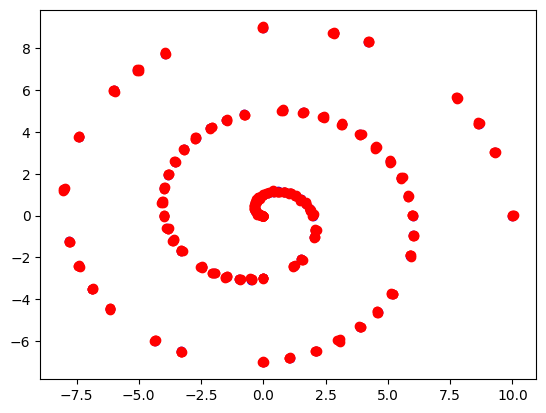

In [ ]:
def relu(x):
    return np.maximum(0,x)
def drelu(x):
    return x>=0

n = 100  # Number of points for a single class
d = 3

def spiral_xy(i):
    """
    Create the data for a spiral.

    Arguments:
        i runs from 0 to n - 1
    """
    φ = i / 20 * math.pi  # Adjust the scaling factor for a smoother spiral
    r = 10.0 * ((n - i) / n)
    x = r * math.cos(φ)
    y = r * math.sin(φ)
    return (x, y)

def spiral():
    return [spiral_xy(i) for i in range(n)]

# Generate spiral data
data = spiral()
X_raw = np.array(data)

index = np.arange(n)
np.random.seed(1)
np.random.shuffle(index)
train_num = int(0.8 * n)  # Use 80% for training and 20% for testing
#training_data_np = X_raw[index[:train_num], :]
training_data_np_clean = X_raw[index[:train_num], :]
test_data_np = X_raw[index[train_num:], :]

training_labels_matrix = np.zeros(training_data_np_clean.shape)
training_data_matrix = np.zeros(training_data_np_clean.shape)
sigma = 0.03
for i in range(5):
    #add noise to training_data_np
    noise = np.random.normal(0, sigma, training_data_np_clean.shape)
    training_data_matrix = np.append(training_data_matrix, training_data_np_clean + noise, axis=0)
    training_labels_matrix = np.append(training_labels_matrix, noise, axis=0)

#append noise to the matrix of labels y
training_data_np = training_data_matrix

#plot training_data_np
plt.scatter(training_data_np_clean[:,0], training_data_np_clean[:,1])    
plt.scatter(training_data_matrix[:,0], training_data_matrix[:,1], c='r')
plt.savefig('./spiral')

In [95]:
# Lasso reg path based on cvxpy
p = 2
n, Embedding_Size = np.shape(training_data_np)
assert Embedding_Size==2, 'wrong input dimension'
G = np.zeros([3,n*(n-1)])
count = 0
for i in range(n):
    for j in range(i+1,n):
        xi = training_data_np[i]
        xj = training_data_np[j]
        if abs(np.linalg.norm(xi-xj))>1e-3:
            v = (xi-xj)/np.linalg.norm(xi-xj)
        else:
            continue
        G[:2,count] = v
        G[2,count] = -xj@v
        G[:2,count+1] = -v
        G[2,count+1] = xi@v
        count+=2
training_data_aug = np.concatenate([training_data_np,np.ones([n,1])],axis=1)
Embedding_Size += 1

dmat= drelu(np.matmul(training_data_aug,G))

#G = G/np.linalg.norm(G[:-1,:],p,axis=0)
threshold = 1e-5  # Define a threshold for small values
norms = np.linalg.norm(G[:-1, :], p, axis=0)  # Calculate norms
norms[norms < threshold] = np.inf  # Replace small norms with infinity to avoid division
G = G / norms  # Perform the division

X = relu(training_data_aug@G)
# append a column of ones to the vector y

#beta_max = 28.5#np.max(X.T@y)
#n_betas = 10
#beta_list = beta_max * np.geomspace(1, 5e-8, n_betas)
beta_list = [0.1]
m1=G.shape[1]
z = cp.Variable((m1,2))
t = cp.Variable((1,2))
yopt = X@z+t
regularization = cp.sum(cp.norm(z, axis=1))
#change regularization to group l1 norm


params_list = []
for e, beta in enumerate(beta_list):
    cost=cp.sum_squares(yopt-training_labels_matrix/sigma)+beta*regularization
    prob=cp.Problem(cp.Minimize(cost))
    cvx_solver = cp.MOSEK
    prob.solve(solver=cvx_solver,verbose=True)
    z_v, t_v = z._value, t._value
    params_list.append([z_v, t_v, G])

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) May 16 05:48:38 PM: Your problem has 459842 variables, 0 constraints, and 0 parameters.
(CVXPY) May 16 05:48:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 16 05:48:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 16 05:48:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 16 05:48:38 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 16 05:48:38 PM: Compiling problem (target solver=MOSEK).

In [8]:
samp=100
x1=np.linspace(-10,10,samp).reshape(-1,1)
x2=np.linspace(-10,10,samp).reshape(-1,1)

Xtest=np.meshgrid(x1,x2)
# add the bias term
Xtest_raw = np.concatenate([Xtest[0].reshape(samp**2,1),Xtest[1].reshape(samp**2,1)],axis=1)
Xtest = np.concatenate([Xtest_raw,np.ones(samp**2).reshape(samp**2,1)],axis=1)

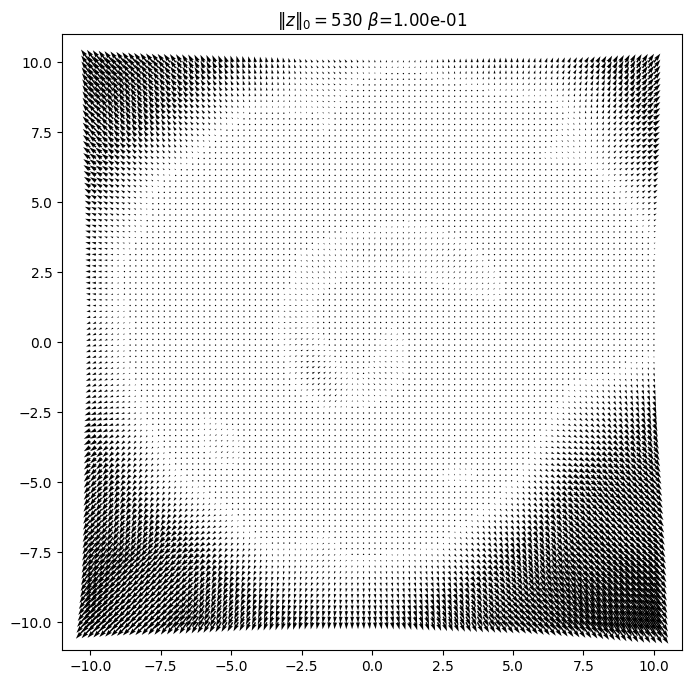

In [9]:
os.makedirs('./figures', exist_ok = True)
fig, ax = plt.subplots(1, 1,figsize=(8,8))
def make_frame(e):
    ax.clear()
    #e = int(e * 6)
    beta = beta_list[e]
    z, t = params_list[e]
    yest_cvx = relu(Xtest@G)@z+t
    #plot the vector field yest_cvx
    U = yest_cvx[:, 0].reshape(samp, samp)
    V = yest_cvx[:, 1].reshape(samp, samp)
    # ax.set_xlim([-3, 3])
    ax.quiver(x1, x2, U, V)
    title = r"$\|z\|_0=${} $\beta$={:.2e}".format(np.sum(np.abs(z) > 1e-2), beta)
    ax.set_title(title)

make_frame(0)
#for e, beta in enumerate(beta_list):
#    make_frame(e)

# Annealed Langevin

In [8]:
def cvx_fit(training_data_np, training_labels_matrix):
    # Lasso reg path based on cvxpy
    p = 2
    n, Embedding_Size = np.shape(training_data_np)
    assert Embedding_Size==2, 'wrong input dimension'
    G = np.zeros([3,n*(n-1)])
    count = 0
    for i in range(n):
        for j in range(i+1,n):
            xi = training_data_np[i]
            xj = training_data_np[j]
            if abs(np.linalg.norm(xi-xj))>1e-3:
                v = (xi-xj)/np.linalg.norm(xi-xj)
            else:
                continue
            G[:2,count] = v
            G[2,count] = -xj@v
            G[:2,count+1] = -v
            G[2,count+1] = xi@v
            count+=2
    training_data_aug = np.concatenate([training_data_np,np.ones([n,1])],axis=1)
    Embedding_Size += 1

    dmat= drelu(np.matmul(training_data_aug,G))

    #G = G/np.linalg.norm(G[:-1,:],p,axis=0)
    threshold = 1e-5  # Define a threshold for small values
    norms = np.linalg.norm(G[:-1, :], p, axis=0)  # Calculate norms
    norms[norms < threshold] = np.inf  # Replace small norms with infinity to avoid division
    G = G / norms  # Perform the division
    X = relu(training_data_aug@G)
    beta = 0.1
    m1=G.shape[1]
    z = cp.Variable((m1,2))
    t = cp.Variable((1,2))
    yopt = X@z+t
    regularization = cp.sum(cp.norm(z, axis=1))
    #change regularization to group l1 norm
    params_list = []
    cost=cp.sum_squares(yopt-training_labels_matrix/sigma)+beta*regularization
    prob=cp.Problem(cp.Minimize(cost))
    cvx_solver = cp.MOSEK
    prob.solve(solver=cvx_solver,verbose=True)
    z_v, t_v = z._value, t._value
    return [z_v, t_v, G]

In [9]:
# train different models for different noise levels
ztG_collect = {}
for sigma in [0.5,0.1,0.05,0.03,0.01]:
    # Generate spiral data
    data = spiral()
    X_raw = np.array(data)

    index = np.arange(n)
    np.random.seed(1)
    np.random.shuffle(index)
    train_num = int(0.8 * n)  # Use 80% for training and 20% for testing
    #training_data_np = X_raw[index[:train_num], :]
    training_data_np_clean = X_raw[index[:train_num], :]
    test_data_np = X_raw[index[train_num:], :]

    training_labels_matrix = np.zeros(training_data_np_clean.shape)
    training_data_matrix = np.zeros(training_data_np_clean.shape)
    print(f'{sigma=}')
    for i in range(5):
        print(f'{i=}')
        #add noise to training_data_np
        noise = np.random.normal(0, sigma, training_data_np_clean.shape)
        training_data_matrix = np.append(training_data_matrix, training_data_np_clean + noise, axis=0)
        training_labels_matrix = np.append(training_labels_matrix, noise, axis=0)

    #append noise to the matrix of labels y
    training_data_np = training_data_matrix
    ztG_collect[sigma] = cvx_fit(training_data_np, training_labels_matrix)


sigma=0.5
i=0
i=1
i=2
i=3
i=4
                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) May 16 04:17:17 PM: Your problem has 459842 variables, 0 constraints, and 0 parameters.
(CVXPY) May 16 04:17:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 16 04:17:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 16 04:17:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 16 04:17:17 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 16 04:17:17 PM: Compiling 

sigma=0.5
iter=0
iter=1
iter=2
iter=3
iter=4
iter=5
iter=6
iter=7
iter=8
iter=9
iter=10
iter=11
iter=12
iter=13
iter=14
iter=15
iter=16
iter=17
iter=18
iter=19
iter=20
iter=21
iter=22
iter=23
iter=24
iter=25
iter=26
iter=27
iter=28
iter=29
iter=30
iter=31
iter=32
iter=33
iter=34
iter=35
iter=36
iter=37
iter=38
iter=39
sigma=0.1
iter=0
iter=1
iter=2
iter=3
iter=4
iter=5
iter=6
iter=7
iter=8
iter=9
iter=10
iter=11
iter=12
iter=13
iter=14
iter=15
iter=16
iter=17
iter=18
iter=19
iter=20
iter=21
iter=22
iter=23
iter=24
iter=25
iter=26
iter=27
iter=28
iter=29
iter=30
iter=31
iter=32
iter=33
iter=34
iter=35
iter=36
iter=37
iter=38
iter=39
sigma=0.05
iter=0
iter=1
iter=2
iter=3
iter=4
iter=5
iter=6
iter=7
iter=8
iter=9
iter=10
iter=11
iter=12
iter=13
iter=14
iter=15
iter=16
iter=17
iter=18
iter=19
iter=20
iter=21
iter=22
iter=23
iter=24
iter=25
iter=26
iter=27
iter=28
iter=29
iter=30
iter=31
iter=32
iter=33
iter=34
iter=35
iter=36
iter=37
iter=38
iter=39
sigma=0.03
iter=0
iter=1
iter=2
iter=3


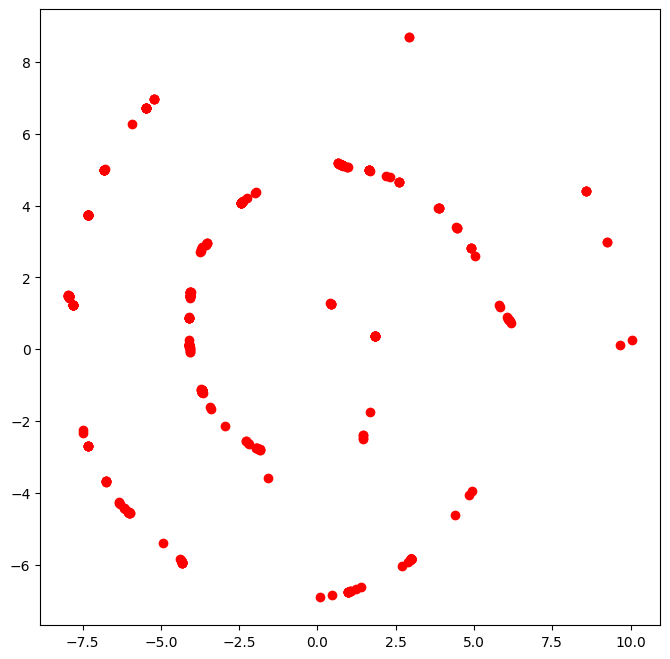

In [15]:
np.random.seed(8) # 6 and 8
fig, ax = plt.subplots(1, 1,figsize=(8,8))
xvec = np.random.uniform(-10,10,size=(500,2))
eps_0 = 0.01
for sigma in [0.5,0.1,0.05,0.03,0.01]:
# for sigma in [0.5]:
    print(f'{sigma=}')
    eps = eps_0*(sigma/0.01)**2
    # eps = 0.03
    z, t, G = ztG_collect[sigma]
    for iter in range(40):
        print(f'{iter=}')
        xvecnew = xvec - eps/2* (relu((np.concatenate([xvec,np.ones(500).reshape(500,1)],axis=1))@G)@z+t) + np.sqrt(eps) * np.random.normal(0,1,2)
        xvecnew = xvecnew.squeeze()
        xvec = xvecnew
ax.scatter(xvec[:,0], xvec[:,1], c='r')
plt.show()


sigma=0.5
iter=0
iter=1
iter=2
iter=3
iter=4


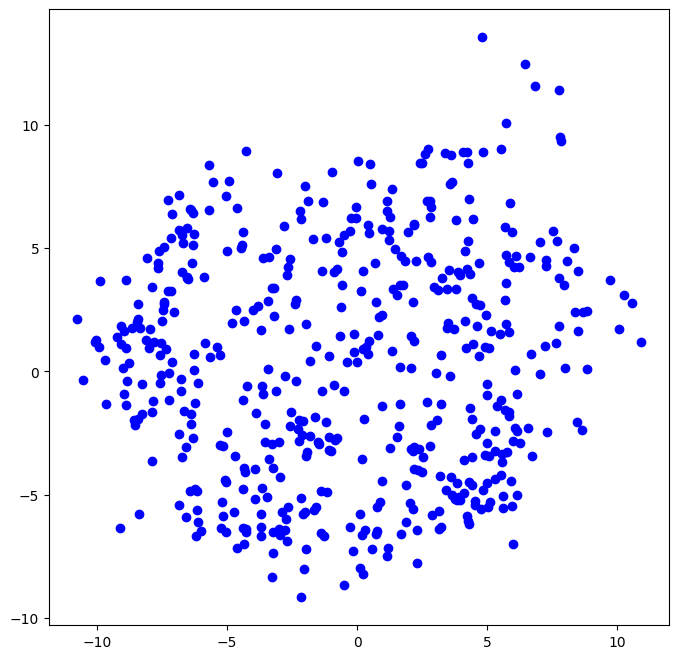

In [218]:
np.random.seed(8) # 6 and 8
fig, ax = plt.subplots(1, 1,figsize=(8,8))
xvec = np.random.uniform(-10,10,size=(500,2))
eps_0 = 1e-3
for sigma in [0.5]:
# for sigma in [0.5]:
    print(f'{sigma=}')
    # eps = eps_0*(sigma/0.01)**2
    eps = 1
    z, t, G = ztG_collect[sigma]
    for iter in range(5):
        print(f'{iter=}')
        xvecnew = xvec - eps/2* (relu((np.concatenate([xvec,np.ones(500).reshape(500,1)],axis=1))@G)@z+t) + np.sqrt(eps) * np.random.normal(size=xvec.shape)
        xvecnew = xvecnew.squeeze()
        xvec = xvecnew
ax.scatter(xvec[:,0], xvec[:,1], c='b')
# plt.show()
plt.savefig('../Documents/research/diffusion/05')

sigma=0.1
iter=0
iter=1
iter=2
iter=3
iter=4


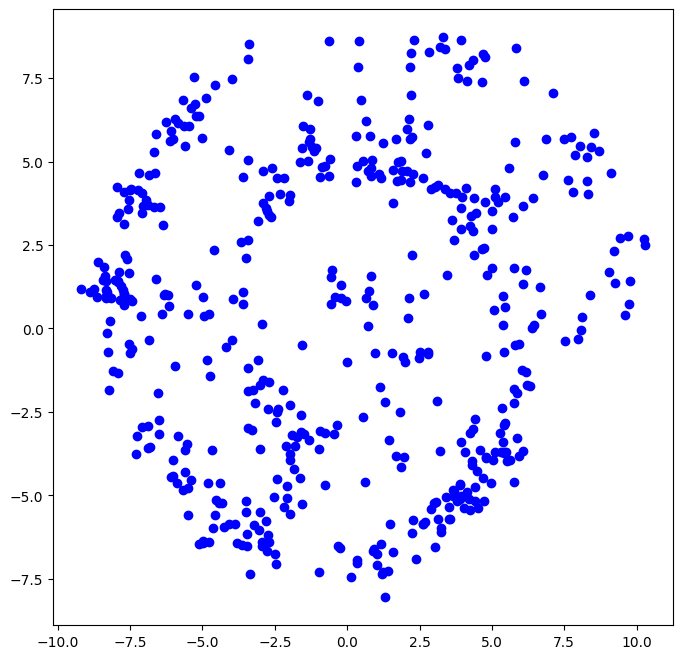

In [219]:
np.random.seed(8) # 6 and 8
fig, ax = plt.subplots(1, 1,figsize=(8,8))
for sigma in [0.1]:
    print(f'{sigma=}')
    # eps = eps_0*(sigma/0.01)**2
    eps = 0.1
    z, t, G = ztG_collect[sigma]
    for iter in range(5):
        print(f'{iter=}')
        xvecnew = xvec - eps/2* (relu((np.concatenate([xvec,np.ones(500).reshape(500,1)],axis=1))@G)@z+t) + np.sqrt(eps) * np.random.normal(size=xvec.shape)
        xvecnew = xvecnew.squeeze()
        xvecnew = xvecnew.squeeze()
        xvec = xvecnew
ax.scatter(xvec[:,0], xvec[:,1], c='b')
# plt.show()
plt.savefig('../Documents/research/diffusion/01')

sigma=0.05
iter=0
iter=1
iter=2
iter=3
iter=4


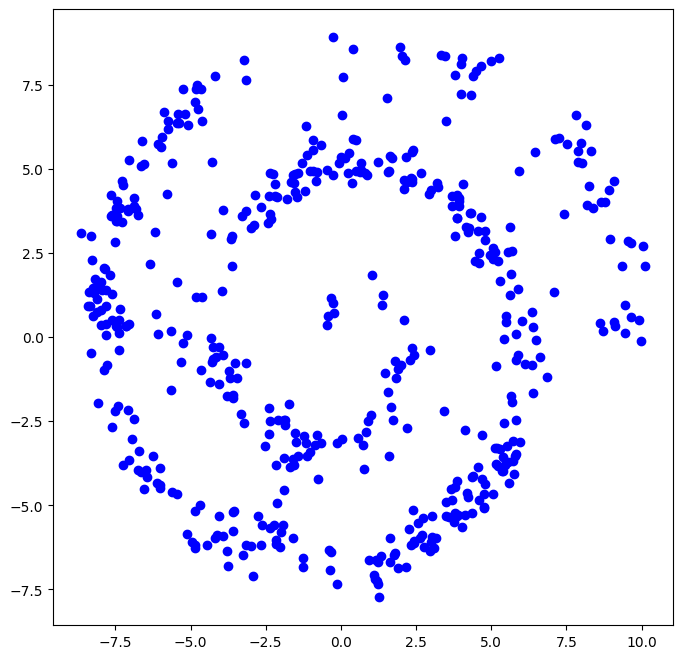

In [220]:
np.random.seed(8) # 6 and 8
fig, ax = plt.subplots(1, 1,figsize=(8,8))
for sigma in [0.05]:
    print(f'{sigma=}')
    # eps = eps_0*(sigma/0.01)**2
    # eps = 5e-3*(sigma/0.01)**2
    eps = 0.1
    z, t, G = ztG_collect[sigma]
    for iter in range(5):
        print(f'{iter=}')
        xvecnew = xvec - eps/2* (relu((np.concatenate([xvec,np.ones(500).reshape(500,1)],axis=1))@G)@z+t) + np.sqrt(eps) * np.random.normal(size=xvec.shape)
        xvecnew = xvecnew.squeeze()
        xvec = xvecnew
ax.scatter(xvec[:,0], xvec[:,1], c='b')
# plt.show()
plt.savefig('../Documents/research/diffusion/005')

sigma=0.03
iter=0
iter=1
iter=2
iter=3
iter=4


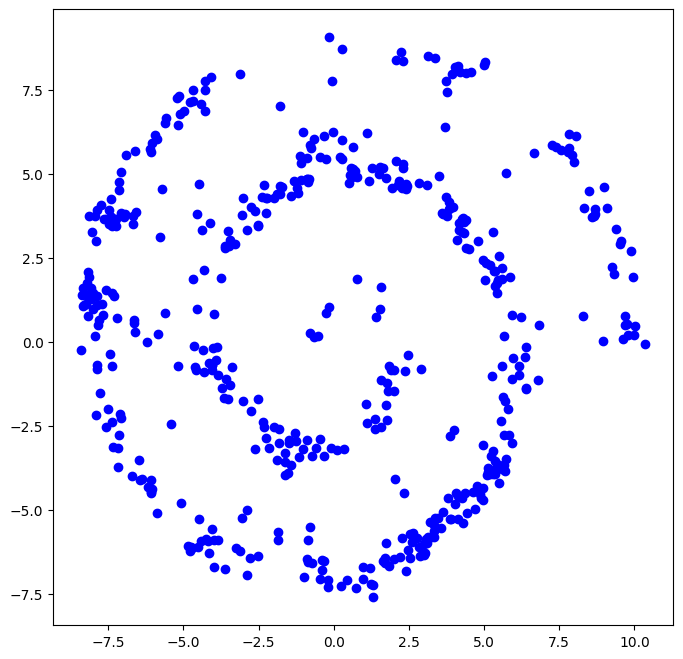

In [221]:
np.random.seed(8) # 6 and 8
fig, ax = plt.subplots(1, 1,figsize=(8,8))
for sigma in [0.03]:
    print(f'{sigma=}')
    # eps = eps_0*(sigma/0.01)**2
    # eps = 5e-3*(sigma/0.01)**2
    eps = 0.05
    z, t, G = ztG_collect[sigma]
    for iter in range(5):
        print(f'{iter=}')
        xvecnew = xvec - eps/2* (relu((np.concatenate([xvec,np.ones(500).reshape(500,1)],axis=1))@G)@z+t) + np.sqrt(eps) * np.random.normal(size=xvec.shape)
        xvec = xvecnew
ax.scatter(xvec[:,0], xvec[:,1], c='b')
# plt.show()
plt.savefig('../Documents/research/diffusion/003')

sigma=0.01
iter=0
iter=1
iter=2
iter=3
iter=4
iter=5
iter=6
iter=7
iter=8
iter=9
iter=10
iter=11
iter=12
iter=13
iter=14


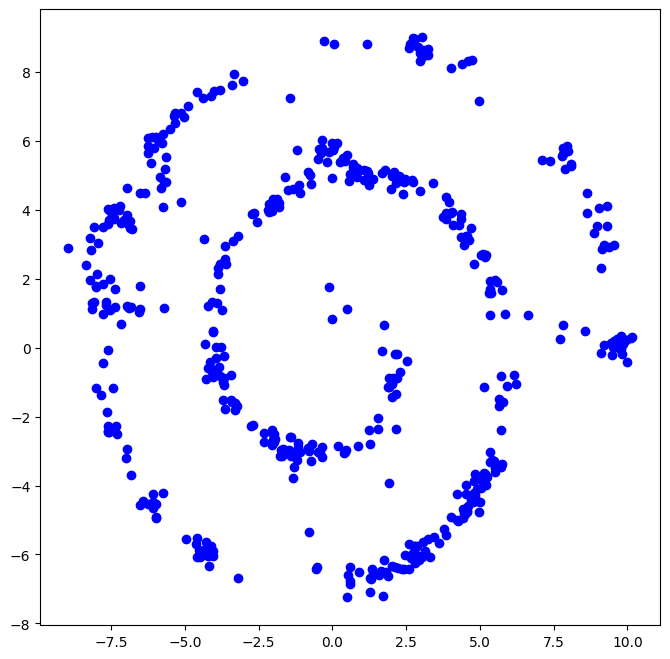

In [222]:
np.random.seed(8) # 6 and 8
fig, ax = plt.subplots(1, 1,figsize=(8,8))
for sigma in [0.01]:
    print(f'{sigma=}')
    # eps = eps_0*(sigma/0.01)**2
    # eps = 1e-2*(sigma/0.01)**2
    eps = 0.03
    z, t, G = ztG_collect[sigma]
    for iter in range(15):
        print(f'{iter=}')
        xvecnew = xvec - eps/2* (relu((np.concatenate([xvec,np.ones(500).reshape(500,1)],axis=1))@G)@z+t) + np.sqrt(eps) * np.random.normal(size=xvec.shape)
        xvecnew = xvecnew.squeeze()
        xvec = xvecnew
ax.scatter(xvec[:,0], xvec[:,1], c='b')
#plt.show()
plt.savefig('../Documents/research/diffusion/001')